In [2]:
import numpy as np
import pandas as pd
import glob
import xarray as xr
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib.animation import PillowWriter
from matplotlib import animation
from scipy import stats

import sys; sys.path.insert(1, '/saturn/simu_Caribbean/coupled_2km')
import os

import geometry as gm
#import conversion as cnv
#from func_statistics import compute_pdf_nbin, slopes_r_p, slope_time, slope_maps
from pdist_fb_distrib_save_fast import *
#from coare_functions import *
import meteo
import lcl
import cartopy.crs as ccrs
crs = ccrs.PlateCarree()
#from plotmap import plot_background
from plotdistr import fb_distribution_npoint, perc_distribution, scatterplot_fit, hist2d
import warnings; warnings.filterwarnings("ignore")

# Building some viz for the surface fluxes article

In [38]:
# read  data
path_data = '/saturn/simu_Caribbean/forced_3km/CNT/FEB/01/'
wrf_files = path_data + 'wrfout_d02_2020-0'
fname_list = sorted(glob.glob(wrf_files + '*'))
ds = xr.open_mfdataset(fname_list, concat_dim='Time', combine='nested')

In [39]:
minlon = -60.; maxlon = -51.
minlat = 0.; maxlat = 17.
# select domain
mask_lon = (ds.XLONG >= minlon) & (ds.XLONG <= maxlon)
mask_lat = (ds.XLAT >= minlat) & (ds.XLAT <= maxlat)
ds = ds.where(mask_lon & mask_lat, drop=True)

In [40]:
# def lon lat time
lon = ds['XLONG'][0].values
lat = ds['XLAT'][0].values
time = ds['XTIME'].values.astype('<M8[s]')
# land - sea mask
lakemask = ds['LAKEMASK'][0].values
landmask = ds['LANDMASK'][0].values
seamask = 1 - lakemask - landmask
seamask[seamask==0] = np.nan
# def extended land-sea mask
seamask_nocoast = seamask.copy(); seamask_island0 = seamask.copy()
seamask_island0[:int(seamask_island0.shape[0]/2),:] = 1
seamask_island = seamask_island0.copy()
for i in range(0,5):
    for j in range(0,5):
        seamask_nocoast = np.roll(seamask, (i,j), axis=(1,0))*seamask_nocoast
        seamask_island = np.roll(seamask_island0, (-i,-j), axis=(1,0))*seamask_island
seamask_nocoast = seamask_nocoast*seamask_island
seamask = seamask_nocoast.copy()
del seamask_nocoast, lakemask, landmask

In [44]:
sst_day = ds['SST'].groupby('XTIME.day').mean().values*seamask - 273.15 # °C

LHF_file = '/dagobah/WRF_EUREC4A/COARE35/Fluxes/FEB/01/LHF_daily_coare35_d02_2020-02'
ds_tmp = xr.open_dataset(LHF_file) # gia fatto ritaglio lonlat
LHF = ds_tmp['LHF'].values*seamask
del ds_tmp


In [45]:
sst_day.shape

(29, 446, 323)

In [46]:
s = 65

dLHF = np.zeros(LHF.shape)
dsst_day = np.zeros(sst_day.shape)

for t in range(0,sst_day.shape[0]):
    if t % 10 == 0:
        print(t)
    
    sst_ave = gm.nan_gaussian_filter(sst_day[t],s)                             
    dsst_day[t] = sst_day[t] - sst_ave
    
    lhf_ave = gm.nan_gaussian_filter(LHF[t], s)                             
    dLHF[t] = LHF[t] - lhf_ave

0
10
20


In [64]:
def local_variance(field,sigma):
    bar = gm.nan_gaussian_filter(field**2,sigma)
    return bar

def local_covariance(field_a,field_b,sigma):
    bar = gm.nan_gaussian_filter(field_a*field_b,sigma)
    return bar

def local_correlation(field_a, field_b, sigma):
    bar = local_covariance(field_a, field_b, sigma)/np.sqrt((local_variance(field_a, sigma))*(local_variance(field_b, sigma)))
    return bar

corr_dsst_dLHF = np.zeros_like(dsst_day)
for t in range(dsst_day.shape[0]):
    corr_dsst_dLHF[t] = local_correlation(dsst_day[t], dLHF[t], s)

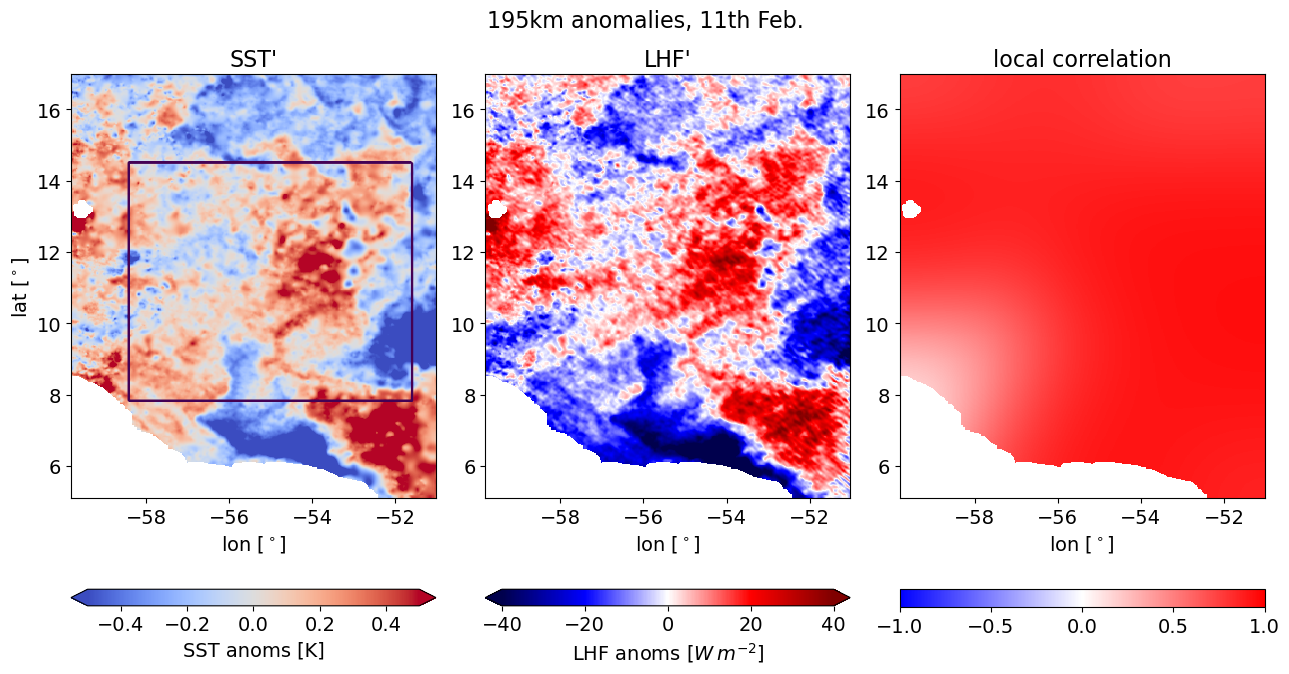

In [86]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13, 7))
plt.suptitle('195km anomalies, 11th Feb.', fontsize=16)
day = int(10)

#######################################################

sst_map = ax1.pcolormesh(lon, lat, dsst_day[day], vmin=-0.5, vmax=0.5, cmap='coolwarm')
cbar1 = plt.colorbar(sst_map, ax=ax1, label=r'SST anoms [K]', extend='both', location='bottom', pad=0.15)
cbar1.ax.tick_params(labelsize=14)  # Set fontsize for colorbar ticks
cbar1.set_label(r'SST anoms [K]', fontsize=14)  # Set fontsize for colorbar label
ax1.set_xlabel('lon [$^\circ$]', fontsize=14)
ax1.set_ylabel('lat [$^\circ$]', fontsize=14)
ax1.set_title("SST'", fontsize=16)

####  Fourier  Mask  ###
fourier_region = np.zeros_like(lat)
# fourier_region[101:351, 51:301] = 1
fourier_region[101,51:301] = 1; fourier_region[351,51:301] = 1
fourier_region[101:351,51] = 1; fourier_region[101:351,301] = 1
ax1.contour(lon, lat, fourier_region, levels=[0.9, 1.1], linewidth=2) #, hatches=['.'], colors='none', alpha=0.01) with contourf

#######################################################

lhf_map = ax2.pcolormesh(lon, lat, dLHF[day], vmin=-40, vmax=40, cmap='seismic')
cbar2 = plt.colorbar(lhf_map, ax=ax2, label=r'LHF anoms [$W\,m^{-2}$]', extend='both', location='bottom', pad=0.15)
cbar2.ax.tick_params(labelsize=14)  # Set fontsize for colorbar ticks
cbar2.set_label(r'LHF anoms [$W\,m^{-2}$]', fontsize=14)  # Set fontsize for colorbar label
ax2.set_xlabel('lon [$^\circ$]', fontsize=14)
ax2.set_title("LHF'", fontsize=16)


###############################################

corr_map = ax3.pcolormesh(lon, lat, corr_dsst_dLHF[day], vmin=-1, vmax=1, cmap='bwr')
cbar3 = plt.colorbar(corr_map, ax=ax3, label=r'', location='bottom', pad=0.15)
cbar3.ax.tick_params(labelsize=14)  # Set fontsize for colorbar ticks
cbar3.set_label(r'', fontsize=14)  # Set fontsize for colorbar label
ax3.set_xlabel('lon [$^\circ$]', fontsize=14)
ax3.set_title("local correlation", fontsize=16)








# Set fontsize for tick labels
ax1.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)
ax3.tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()



In [2]:
# find data
path = '/saturn/simu_Caribbean/coupled_2km/output/'
files_ls = ['QCLOUD', 'U', 'V', 'W', 'OLR', 'PH', 'PHB', 'QVAPOR', 'PB', 'P', 'T']
files_ls = [name + '.nc' for name in files_ls]
wrf_files = [path+name for name in files_ls]
#fname_list = sorted(glob.glob(wrf_files + '*'))

In [3]:
# import sea_mask
if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_nobnd_EU.npy'):
    sea_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_nobnd_EU.npy')

if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_noWarmPatch_noWest.npy'):
    sea_mask_modified = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_noWarmPatch_noWest.npy')
    sea_mask_modified_nan = np.ones_like(sea_mask_modified)
    sea_mask_modified_nan[sea_mask_modified==0] = np.nan
    
tourbillons_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/tourbillons_mask.npy')
open_ocean_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/open_ocean_mask.npy')

In [4]:
wrf_hourly = path + 'Caraibes_WRF_3h_surf.nc'
ds_hourly = xr.open_dataset(wrf_hourly)
ds_hourly = ds_hourly.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))


sst = ds_hourly['SST'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))
sst_day = sst.groupby('time_counter.day').mean()

In [5]:
lon = ds_hourly['nav_lon'].values
lat = ds_hourly['nav_lat'].values

In [6]:
ds_sst = xr.open_dataset('/venus/tesi_ale/data_EU/SST/hourly/FEB/dSST_feb.nc')
dsst_day = ds_sst['dsst_day'].values*sea_mask_modified_nan

In [7]:
sst_day_sm = sst_day - dsst_day

In [7]:
s = 100

# dsst_day = np.zeros(sst_day.shape)
dsst_day_OO = np.zeros(sst_day.shape)
dsst_day_TOURB = np.zeros(sst_day.shape)

for t in range(0,sst_day.shape[0]):
    if t % 10 == 0:
        print(t)
    # upscale using gaussian filter
#     sst_day_ave = gm.nan_gaussian_filter(sst_day[t].values*sea_mask_modified_nan,s)          
#     dsst_day[t] = sst_day[t] - sst_day_ave
    
    sst_day_ave = gm.nan_gaussian_filter(sst_day[t].values*open_ocean_mask,s)          
    dsst_day_OO[t] = sst_day[t] - sst_day_ave
    
    sst_day_ave = gm.nan_gaussian_filter(sst_day[t].values*tourbillons_mask,s)          
    dsst_day_TOURB[t] = sst_day[t] - sst_day_ave

0
10
20


Text(0, 0.5, 'lat [$^\\circ$]')

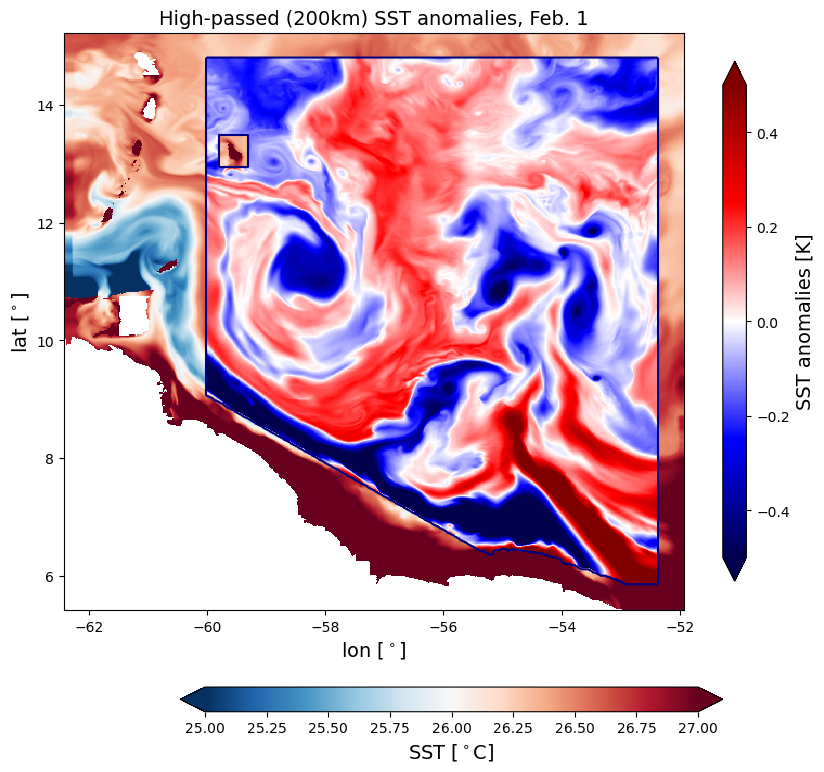

In [21]:
day = int(0)

plt.figure(figsize=(10, 10))

x = (sst_day[day].values-273.15)*(sst_day[day]/sst_day[day])
mesh = plt.pcolormesh(lon, lat, x, vmin=25, vmax=27, cmap='RdBu_r')
cbar = plt.colorbar(mesh, extend='both', location='bottom', shrink=0.7, pad=0.1)
cbar.set_label(label='SST [$^\circ$C]', fontsize=14)

# y = sst_day_sm[day]-273.15
# mesh_sm = plt.pcolormesh(lon, lat, y, vmin=25, vmax=27, cmap='RdBu_r')
# cbar = plt.colorbar(mesh_sm, extend='both')
# cbar.set_label(label='SST smooth [$^\circ$C]', fontsize=14)

mesh_anoms = plt.pcolormesh(lon, lat, dsst_day[day], vmin=-0.5, vmax=0.5, cmap='seismic')
cbar = plt.colorbar(mesh_anoms, extend='both',  shrink=0.9)
cbar.set_label('SST anomalies [K]', fontsize=14)


plt.contour(lon, lat, sea_mask_modified, levels=[0.], cmap='jet')
# plt.clabel(conts, inline=True)


plt.title(f'High-passed (200km) SST anomalies, Feb. {day+1}', fontsize=14)
plt.xlabel('lon [$^\circ$]', fontsize=14)
plt.ylabel('lat [$^\circ$]', fontsize=14)

Text(0, 0.5, 'lat [$^\\circ$]')

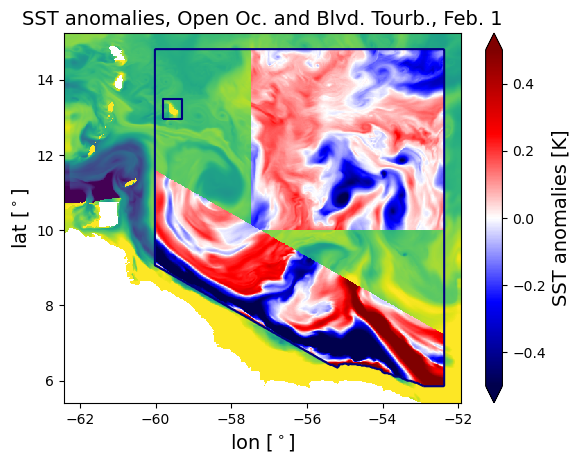

In [12]:
day = int(0)
x = (sst_day[day].values-273.15)*(sst_day[day]/sst_day[day])
mesh = plt.pcolormesh(lon, lat, x, vmin=25, vmax=27, cmap='viridis')
# plt.colorbar(mesh, label='SST [$^\circ$C]', extend='both')

mesh_anoms = plt.pcolormesh(lon, lat, dsst_day_OO[day], vmin=-0.5, vmax=0.5, cmap='seismic')
plt.pcolormesh(lon, lat, dsst_day_TOURB[day], vmin=-0.5, vmax=0.5, cmap='seismic')
cbar = plt.colorbar(mesh_anoms, extend='both')
cbar.set_label('SST anomalies [K]', fontsize=14)


plt.contour(lon, lat, sea_mask_modified, levels=[0.], cmap='jet')
# plt.clabel(conts, inline=True)


plt.title(f'SST anomalies, Open Oc. and Blvd. Tourb., Feb. {day+1}', fontsize=14)
plt.xlabel('lon [$^\circ$]', fontsize=14)
plt.ylabel('lat [$^\circ$]', fontsize=14)

## looking for the 20th and 80th percentiles in dSST

In [17]:
# lat and lon
lon = ds_hourly['nav_lon'].values
lat = ds_hourly['nav_lat'].values

perc_20, perc_80 = np.zeros(29), np.zeros(29)

for i in range(29):
    perc_20[i] = np.nanpercentile(dsst_day[i,:,:], 20)
    perc_80[i] = np.nanpercentile(dsst_day[i,:,:], 80)

Text(0, 0.5, 'lat [$^\\circ$]')

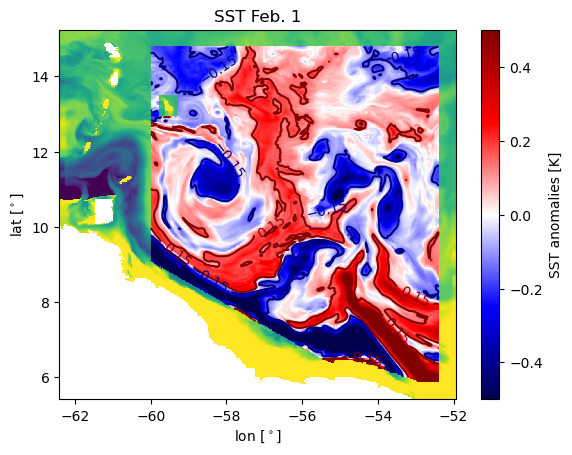

In [42]:
day = int(0)
x = (sst_day[day].values-273.15)*(sst_day[day]/sst_day[day])
mesh = plt.pcolormesh(lon, lat, x, vmin=25, vmax=27, cmap='viridis')
# plt.colorbar(mesh, label='SST [$^\circ$C]', extend='both')

mesh_anoms = plt.pcolormesh(lon, lat, dsst_day[day], vmin=-0.5, vmax=0.5, cmap='seismic')
plt.colorbar(mesh_anoms, label='SST anomalies [K]')

conts = plt.contour(lon, lat, dsst_day[day], levels=[round(perc_20[day],2), round(perc_80[day],2)], cmap='jet')
plt.clabel(conts, inline=True)


plt.title(f'SST Feb. {day+1}')
plt.xlabel('lon [$^\circ$]')
plt.ylabel('lat [$^\circ$]')

## comparing sigm_inf, band-pass and high-pass

In [4]:
ds_bp = xr.open_dataset('/venus/tesi_ale/data_EU/VARIANCE_LHF/daily/FEB/ForCouComparison/NEW_ALE_band-pass_lhfRH_dailyMeans_all.nc')
ds_hp = xr.open_dataset('/venus/tesi_ale/data_EU/VARIANCE_LHF/daily/FEB/ForCouComparison/NEW_ALE_passalto_lhfRH_dailyMeans_all.nc')
# ds_inf = xr.open_dataset('/venus/tesi_ale/data_EU/VARIANCE_LHF/daily/FEB/ForCouComparison/NEW_ALE_sigma-inf_lhfRH_dailyMeans_all.nc')


Text(0.5, 0, 'lon [$^\\circ$]')

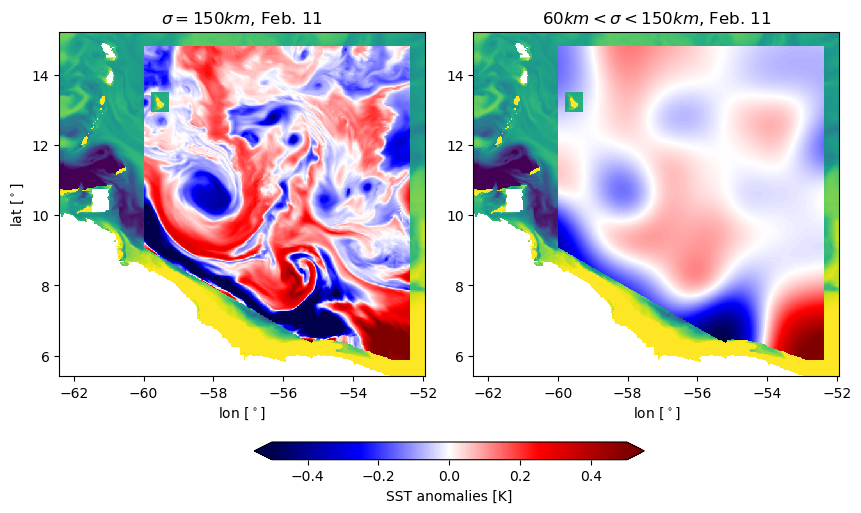

In [22]:
day = int(10)

fig, axs = plt.subplots(1,2, figsize=(8.5,5), constrained_layout=True)

# #### sigma inf
# x = (sst_day[day].values-273.15)*(sst_day[day]/sst_day[day])
# mesh = axs[0].pcolormesh(lon, lat, x, vmin=25, vmax=27, cmap='viridis')

# xx = ds_inf['sst_prime']
# mesh_anoms = axs[0].pcolormesh(lon, lat, xx[day].values, vmin=-0.5, vmax=0.5, cmap='seismic')

# axs[0].set_title( r"$\sigma = \infty$" + f', Feb. {day+1}')
# axs[0].set_xlabel('lon [$^\circ$]')
# axs[0].set_ylabel('lat [$^\circ$]')



# high-pass 
x = (sst_day[day].values-273.15)*(sst_day[day]/sst_day[day])
mesh = axs[0].pcolormesh(lon, lat, x, vmin=25, vmax=27, cmap='viridis')

xx = ds_hp['sst_prime']
mesh_anoms = axs[0].pcolormesh(lon, lat, xx[day].values, vmin=-0.5, vmax=0.5, cmap='seismic')

axs[0].set_title(r"$\sigma = 150km$" + f', Feb. {day+1}')
axs[0].set_xlabel('lon [$^\circ$]')
axs[0].set_ylabel('lat [$^\circ$]')


### band pass

x = (sst_day[day].values-273.15)*(sst_day[day]/sst_day[day])
mesh = axs[1].pcolormesh(lon, lat, x, vmin=25, vmax=27, cmap='viridis')

xx = ds_bp['sst_prime']
mesh_anoms = axs[1].pcolormesh(lon, lat, xx[day].values, vmin=-0.5, vmax=0.5, cmap='seismic')
fig.colorbar(mesh_anoms, ax=axs[:], label='SST anomalies [K]', extend='both', location='bottom', shrink=0.5)

axs[1].set_title(r"$60km <\sigma < 150km$" + f', Feb. {day+1}')
axs[1].set_xlabel('lon [$^\circ$]')

# plt.tight_layout()

# I don't know what I did from here on

In [2]:
# find data
path = '/saturn/simu_Caribbean/coupled_2km/output/'

wrf_files = path + 'Caraibes_WRF_3h_surf.nc'
#fname_list = sorted(glob.glob(wrf_files + '*'))

In [3]:
# open data - HOURLY
ds_hourly = xr.open_dataset(wrf_files)    #mfdataset(fname_list, concat_dim='Time', combine='nested')
'''ds_hourly = ds_tot.sel(time_counter=slice('2006-02-01T00:30:00.000000000', '2006-02-29T22:30:00.000000000'))
del ds_tot'''
# lat and lon
lon_M = ds_hourly['nav_lon'].values
lat_M = ds_hourly['nav_lat'].values


In [14]:
sst = ds_hourly['SST'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))
sst = sst.groupby('time_counter.day').mean()

In [5]:
# import sea_mask
if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_new.npy'):
    sea_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_new.npy')
if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_noWarmPatch_noWest.npy'):
    sea_mask_modified = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_noWarmPatch_noWest.npy')

In [15]:
sst_classic = sst.where(sea_mask, drop=False)
sst_modified = sst.where(sea_mask_modified, drop=False)

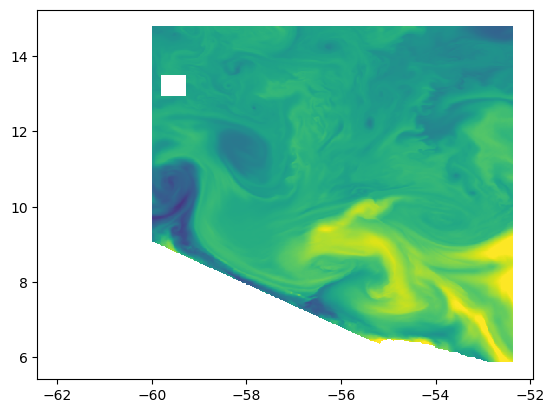

In [16]:
plt.pcolormesh(lon_M, lat_M, sst_modified[25]-273.15, vmin=25, vmax=27, cmap='viridis')

In [17]:
# compute anomalies daily data
s = 100


dsst_classic = np.zeros(sst_classic.values.shape)
dsst_modified = np.zeros(sst_modified.values.shape) 

for t in range(0,sst_classic.shape[0]):
    if t % 10 == 0:
        print(t)
    
    sst_ave_cl = gm.nan_gaussian_filter(sst_classic[t],s)                          
    sst_ave_mo = gm.nan_gaussian_filter(sst_modified[t],s)
    
    dsst_classic[t] = sst_classic[t] - sst_ave_cl
    dsst_modified[t] = sst_modified[t] - sst_ave_mo
    

0
10
20


/venus/tesi_ale/img_EU/SST/comparison_dSST_oldMask_newMask.png


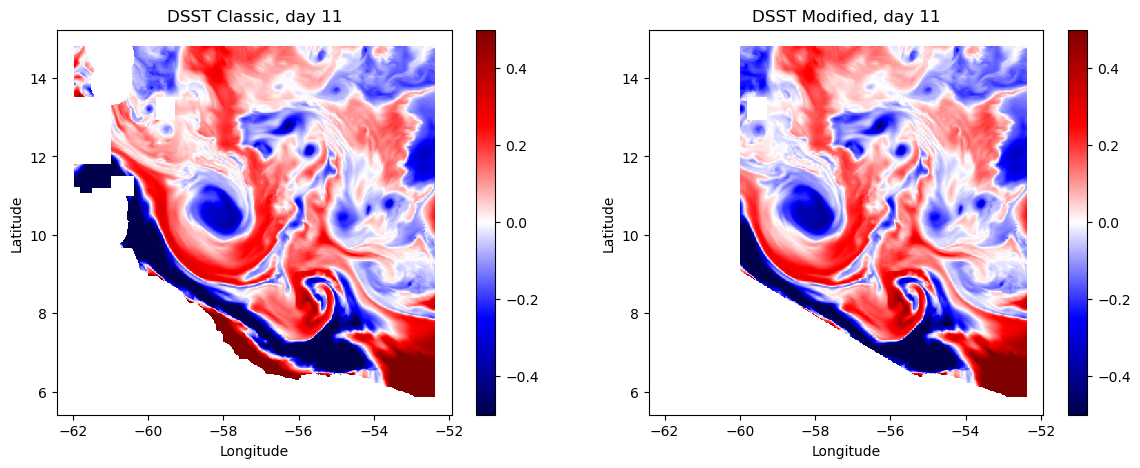

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

day = int(10)

# Plot dsst_classic
c1 = ax1.pcolormesh(lon_M, lat_M, dsst_classic[day], vmin=-0.5, vmax=0.5, cmap='seismic')
ax1.set_title(f'DSST Classic, day {day+1}')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
fig.colorbar(c1, ax=ax1, orientation='vertical')

# Plot dsst_modified
c2 = ax2.pcolormesh(lon_M, lat_M, dsst_modified[day], vmin=-0.5, vmax=0.5, cmap='seismic')
ax2.set_title(f'DSST Modified, day {day+1}')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
fig.colorbar(c2, ax=ax2, orientation='vertical')


path_img = '/venus/tesi_ale/img_EU/SST/' #if perc else '/venus/tesi_ale/img_EU/BV/daily/FEB/'
filename = path_img + 'comparison_dSST_oldMask_newMask.png' #if perc else path_img + 'bins_dsst_dBV_lowtropo.png'
plt.savefig(filename)
print(filename)
del filename

In [24]:
# lon   lat
# -55.5   6.5
# -59   8.5
xlon_index = np.argwhere((lon_M[0,:]>-59) & (lon_M[0,:]<-55.5))
xlon = lon_M[0,xlon_index]

m = (8.5-6.5)/(-59+55.5)

ylat = (xlon+55.5)*m+6.5

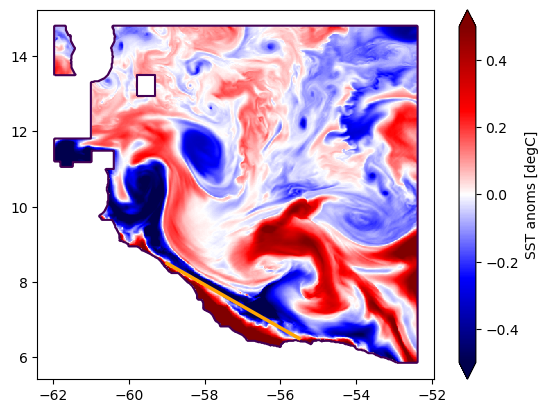

In [25]:
plt.pcolormesh(lon_M, lat_M, dsst_day[25], vmin=-0.5, vmax=0.5, cmap='seismic')
plt.colorbar(extend='both', label='SST anoms [degC]')

plt.contour(lon_M, lat_M, sea_mask, levels=[0.])

plt.plot(xlon, ylat, 'orange', linewidth=2.5)

In [26]:
lat_line = (lon_M[0,:]+55.5)*m+6.5


for i in range(len(lat_M[0,:])):
    sea_mask[ lat_M[:,i]<lat_line[i],i ] = 0


In [30]:
my_save_data('/home/alessandro/thesis_material/EURECA_scripts/sea_mask_EU_noWarmPatch_noWest.npy', [sea_mask_alternative])

creating new file and saving variables


In [28]:
sea_mask_alternative = sea_mask
sea_mask_alternative[lon_M<-60]=0

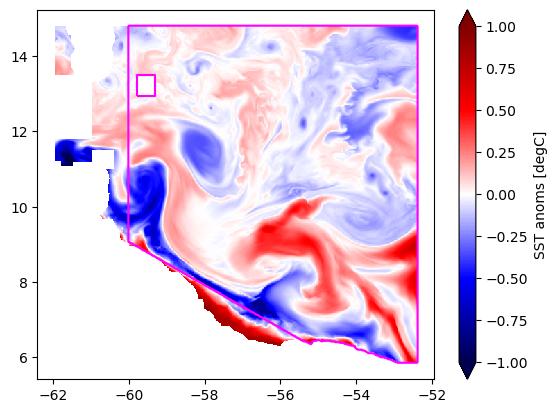

In [29]:
plt.pcolormesh(lon_M, lat_M, dsst_day[25], vmin=-1, vmax=1, cmap='seismic')
plt.colorbar(extend='both', label='SST anoms [degC]')

plt.contour(lon_M, lat_M, sea_mask_alternative, levels=[0.], colors='magenta', linewidth=2.5)

In [ ]:
''''

warm_patches_index = np.argwhere(dsst_day>0.25)
warm_patches_values = dsst_day[warm_patches_index[:,0], warm_patches_index[:,1], warm_patches_index[:,2]]

day = int(25)

plt.pcolormesh(lon_M, lat_M, dsst_day[day,:,:], vmin=0.2, vmax=0.5, cmap='jet')
plt.colorbar(location='right', shrink=0.8, extend='both', label='SST anoms [degC]')  

cont = plt.contour(lon_M, lat_M, dsst_day[day,:,:], levels=[0.3, 0.5], cmap='YlOrRd')
plt.clabel(cont, inline=True, fontsize=10)

plt.xlabel('lon'); plt.ylabel('lat')
plt.title(f'Warmest dSST')'''

'

In [15]:
with open('/venus/tesi_ale/data_EU/SST/daily/FEB/dSST_day_feb.npy', 'rb') as f:
    dsst_day = np.load(f)
    f.close()

<IPython.core.display.Javascript object>


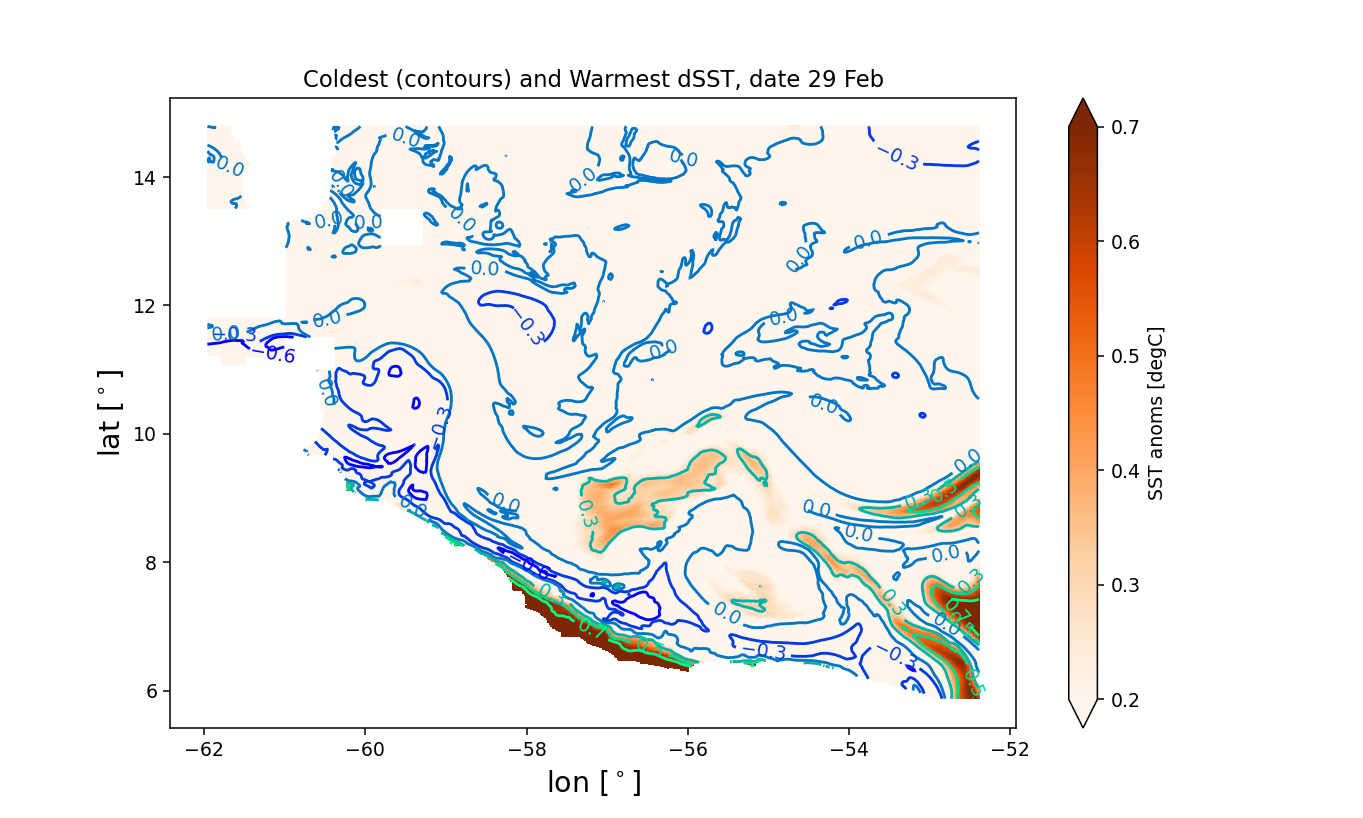

In [16]:
%matplotlib notebook

trange = 29                         #len(ds_hourly['time_counter'].values)
trange = np.arange(trange)
frames = np.arange(0,len(trange))
levs = [-0.6, -0.3, 0., 0.3, 0.5, 0.7]
mindsst, maxdsst = 0.2, 0.7
cont_cmap = 'winter'
mesh_cmap = 'Oranges'

# setting up the figures to be printed
fig = plt.figure(figsize=(10,6))
ax = plt.axes(xlim=(lon_M[0,0], lon_M[0,-1]), ylim=(lat_M[0,0], lat_M[-1,0]), xlabel='lon [$^\circ$]', ylabel='lat [$^\circ$]')

# set initial plot
contf = ax.pcolormesh(lon_M, lat_M, dsst_day[0,:,:], vmin=mindsst, vmax=maxdsst, cmap=mesh_cmap)  
cbar = fig.colorbar(contf, extend='both')
cbar.set_label('SST anoms [degC]')

cont = ax.contour(lon_M, lat_M, dsst_day[0,:,:], levels=levs, cmap=cont_cmap)
ax.clabel(cont, inline=True, fontsize=10)

ax.set_xlabel('lon [$^\circ$]', fontsize=15); ax.set_ylabel('lat [$^\circ$]',fontsize=15)
ax.set_title(f'Coldest (contours) and Warmest dSST')




# Animation function
def animate(i):
    ax.clear()     # clear previous plot
     
    contf = ax.pcolormesh(lon_M, lat_M, dsst_day[i,:,:], vmin=mindsst, vmax=maxdsst, cmap=mesh_cmap)  
    cbar.update_normal(contf)
    #cbar.set_ticks(dsst_levs)
    #cbar.set_ticklabels(dsst_levs.round(decimals=1).astype(str))
    
    cont = ax.contour(lon_M, lat_M, dsst_day[i,:,:], levels=levs, cmap=cont_cmap)
    ax.clabel(cont, inline=True, fontsize=10)
    
    ax.set_xlabel('lon [$^\circ$]', fontsize=15); ax.set_ylabel('lat [$^\circ$]',fontsize=15)
    ax.set_title(f'Coldest (contours) and Warmest dSST, date {trange[i]+1} Feb') 


anima_dsst = animation.FuncAnimation(fig, animate, interval=200, frames=frames, repeat=False)

plt.show()

In [38]:
writer = PillowWriter(fps=1,metadata=dict(artist='Me'),bitrate=1800)
anima_dsst.save('/venus/tesi_ale/img_EU/SST/warmest_coldest_dsst.gif', writer=writer)

# pasticcci per PhD Trieste

In [2]:
# find data
path = '/saturn/simu_Caribbean/coupled_2km/output/'

wrf_files = path + 'Caraibes_WRF_3h_surf.nc'
#fname_list = sorted(glob.glob(wrf_files + '*'))


# open data - HOURLY
ds_hourly = xr.open_dataset(wrf_files)    #mfdataset(fname_list, concat_dim='Time', combine='nested')
'''ds_hourly = ds_tot.sel(time_counter=slice('2006-02-01T00:30:00.000000000', '2006-02-29T22:30:00.000000000'))
del ds_tot'''
# lat and lon
lon_M = ds_hourly['nav_lon'].values
lat_M = ds_hourly['nav_lat'].values


In [22]:
sst = ds_hourly['SST'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-03-01T01:30:00.000000000'))

sst = sst.groupby('time_counter.day').mean()
sst = sst-273.15

In [17]:
#### import the different masks

# import sea_mask
if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_nobnd_EU.npy'):
    sea_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_new.npy')

if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_nobnd_EU.npy'):
    sea_mask_alt = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_noWarmPatch_noWest.npy')


In [6]:
s = 100

dsst = np.zeros_like(sst)

for t in range(0,dsst.shape[0]):
    if t % 10 == 0:
        print(t)
    
    # unmasked sst anomalies
    sst_ave = gm.nan_gaussian_filter(sst[t],s)                             
    dsst[t] = sst[t] - sst_ave

0
10
20


In [19]:
np.nanmax(dsst)

165.81238

In [9]:
plt.pcolormesh(lon_M, lat_M, dsst[0,:,:], vmin=mindsst, vmax=maxdsst, cmap=mesh_cmap)  

In [23]:
sst_mask = sst[10,:,:]/sst[10,:,:]
sst_mask = sst_mask.where(sst_mask>0, other=0, drop=False)
land_mask =  1-sst_mask

<IPython.core.display.Javascript object>


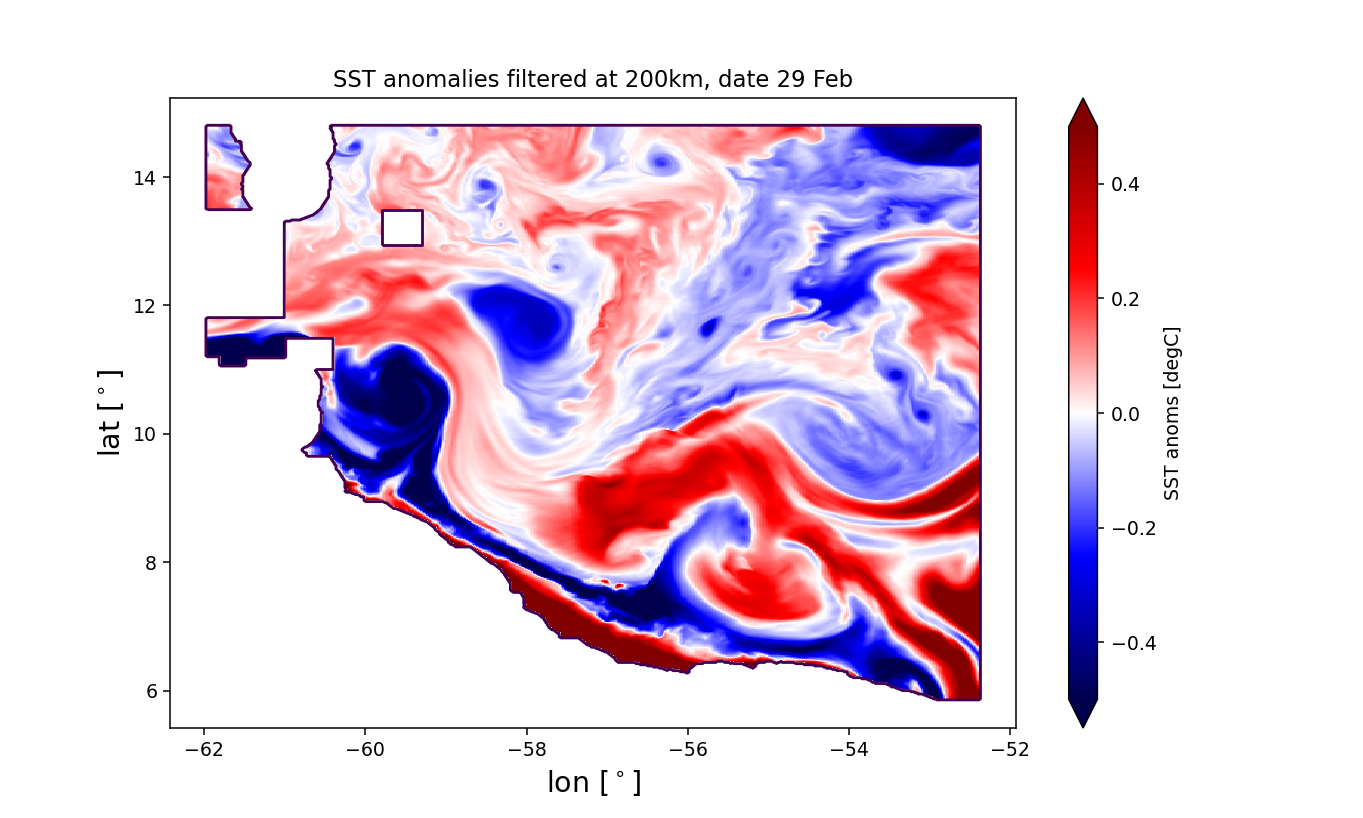

In [40]:
%matplotlib notebook

trange = 29                         #len(ds_hourly['time_counter'].values)
trange = np.arange(trange)
frames = np.arange(0,len(trange))
# levs = [-0.6, -0.3, 0., 0.3, 0.5, 0.7]
mindsst, maxdsst = -0.5, 0.5
#cont_cmap = 'winter'
mesh_cmap = 'seismic'

# setting up the figures to be printed
fig = plt.figure(figsize=(10,6))
ax = plt.axes(xlim=(lon_M[0,0], lon_M[0,-1]), ylim=(lat_M[0,0], lat_M[-1,0]), xlabel='lon [$^\circ$]', ylabel='lat [$^\circ$]')

# set initial plot
contf = ax.pcolormesh(lon_M, lat_M, dsst_day[0,:,:], vmin=mindsst, vmax=maxdsst, cmap=mesh_cmap)  
cbar = fig.colorbar(contf, extend='both')
cbar.set_label('SST anoms [degC]')

cont = ax.contour(lon_M, lat_M, sea_mask, levels=[0.])  #, cmap=cont_cmap)  #dsst_day[0,:,:]

ax.set_xlabel('lon [$^\circ$]', fontsize=15); ax.set_ylabel('lat [$^\circ$]',fontsize=15)
ax.set_title(f'SST anomalies filtered at 200km, date {trange[0]+1} Feb')

# con_mask = ax.contourf(land_mask, levels=[0.9, 1.1], hatches=['...'], colors='none', alpha=0.1)
con_mask = ax.contour(lon_M, lat_M, land_mask.values, levels=[1.])

# Animation function
def animate(i):
    ax.clear()     # clear previous plot
    ax.set_xlabel('lon [$^\circ$]', fontsize=15); ax.set_ylabel('lat [$^\circ$]',fontsize=15)
    ax.set_title(f'SST anomalies filtered at 200km, date {trange[i] + 1} Feb')

    contf = ax.pcolormesh(lon_M, lat_M, dsst_day[i,:,:], vmin=mindsst, vmax=maxdsst, cmap=mesh_cmap)  
    cbar.update_normal(contf)
    #cbar.set_ticks(dsst_levs)
    #cbar.set_ticklabels(dsst_levs.round(decimals=1).astype(str))

    cont = ax.contour(lon_M, lat_M, sea_mask, levels=[0.])

#     con_mask = ax.contourf(land_mask, levels=[0.9, 1.1], hatches=['...'], colors='none', alpha=0.1)
    con_mask = ax.contour(lon_M, lat_M, land_mask.values, levels=[1.])
    
    
anima_dsst = animation.FuncAnimation(fig, animate, interval=200, frames=frames, repeat=False)

plt.show()

In [41]:
writer = PillowWriter(fps=1,metadata=dict(artist='Me'),bitrate=1800)
anima_dsst.save('/home/alessandro/img_dottorato/dsst.gif', writer=writer)